# Auto Feature Engineering Workflow Demo

## Content

* [1. Introduction](#1.-Introduction)
* [2. Auto Feature Engineering workflow](#2.-Auto-Feature-Engineering-Workflow-Demo)
* [3. AutoFE Deep Dive](#3.-AutoFE-Deep-dive)
* [3.1 Profile](#3.1-Feature-Profiling)
* [3.2 Pipeline Plot](#3.2-Pipeline-Plot)
* [3.3 Feature Importance](#3.3-Feature-Importance)
* [4. Model Training](#4.-Model-training)
* [5. Performance](#)

## 1. Introduction

This AutoFE workflow demo shows how to leverage the Auto-Feature-Engineering toolkit (codename:RecDP) to automatically transform raw tabular data to a ready-to-train data with enriched usefull new features, while significantly improve developer productivity and end-to-end data prepration performance.
<center><img src="recdp_autofe_overview.jpg" width = "800" alt = 'recdp_autofe_overview'></center>

AutoFE workflows uses RecDP to: 

(1) Automatically profile the dataset, infer data type of each input columns  
(2) Determines the proper feature engineering primitives with infered data type  
(3) Generates data preparation pipelines with chained operators  
(4) Generates DAG for operations  
(5) Execute DAG on different engines  
(6) Feature importance analsyis  

## 2. Auto Feature Engineering Workflow Demo

### Step 1: Configuration file 
To launch Auto Feature Engineering workflow, only required work is to edit `workflow.yaml`.
Supported configurations are listed in table

| Name            | Description   |
| --------------- | ------------- |
| dataset_path | set dataset directory |
| target_label | specify target lable of dataset|
| engine_type | config auto feature engineering engine type, support pandas and spark |

In [1]:
!cat workflow.yaml

dataset_path: ./raw_data/Covid_19_ICU_prediction.csv
target_label: ICU
engine_type: pandas

### Step 2: Kick off AuoFE workflow 

This toolkit provides Low code API, user only needs to use 3 lines of codes to launch Auto Feature Engineering to any input tabular data.

AutoFE api will analyze dataset and its target label, create data pipeline automatically, and then use specified engine_type to transform data.

You're expected to see transformed data displayed after codes completion.

### 2.1 Integrate third-party function from TabularUtils

In [2]:
# 2.1.2 import tabular-utils
from pyrecdp.primitives.tabutils.utils import linear_impute, masking, delta, statistics, get_slope_stats, qSOFA, MEWS, sliding_window
from pyrecdp.primitives.tabutils.data_preprocess import *
from pyrecdp.primitives.tabutils.feature_normal_transform import *

In [3]:
# 2.1.3 Define customer-specified expert function to process Covid data

patient_ID = "PATIENT_VISIT_IDENTIFIER"
demo_columns = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6','WINDOW','ICU']
exclude_columns = ['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6','WINDOW','ICU']

def select_feature_from_covid_data(df_covid_data):
    include_columns = [x for x in df_covid_data.columns if x not in exclude_columns]
    corr, dist_linkage = create_dendrogram(df_covid_data[include_columns])
    print("Selecting features bassed on the dendogram")
    selected_features = select_feature_with_linkage_matrix(dist_linkage, 1, df_covid_data[include_columns])
    not_selected = [x for x in include_columns if x not in selected_features]
    df_covid_data = df_covid_data[[x for x in df_covid_data.columns if x not in not_selected]]
    return df_covid_data

def feature_impute_for_covid_data(df_covid_data):
    return linear_impute(df_covid_data, patient_ID)

def generate_domain_specific_features_from_covid_data(df_covid_data):
    
    def generate_sliding_window_features_from_covid_data(df_covid_data, include_columns):
        window_length = 2
        df_subset = df_covid_data[include_columns + [patient_ID]]
        df = sliding_window(df_subset, len(df_subset), patient_ID, window_length)
        df_covid_data = pd.concat([df_covid_data[patient_ID], df, df_covid_data.drop(columns=df_subset)],axis=1)
        return df_covid_data
    
    SBP = "BLOODPRESSURE_DIASTOLIC_MEAN-0"
    Temp = "TEMPERATURE_MEAN-0"
    HR = "HEART_RATE_MEAN-0"
    Resp = "RESPIRATORY_RATE_MEAN-0"
    stats = ["var","energy","min","max"]
    include_columns = [x for x in df_covid_data.columns if x not in exclude_columns]

    # 1. get best transform function for all original feature
    best_transform_dict = find_best_normal_transform(df_covid_data)

    # 2. feature engineer
    masked_df = masking(df_covid_data, include_columns)
    df_delta = delta(df_covid_data, patient_ID, demo_columns,  window=1)
    df_stats = statistics(df_covid_data, stats, include_columns, patient_ID, window=2).reset_index(drop=True)
    df_slope = get_slope_stats(df_covid_data, include_columns, patient_ID, window_size=3).reset_index(drop=True)
    df_final = pd.concat([df_covid_data, masked_df, df_stats, df_delta, df_slope], axis=1)

    df_covid_data = generate_sliding_window_features_from_covid_data(df_covid_data, include_columns)
    df_covid_data = qSOFA(df_covid_data,SBP,Resp)
    df_covid_data = MEWS(df_covid_data,Resp,HR,Temp,SBP)
    

    # 3. apply feature transformation
    df_final = apply_best_normal_transform(df_final, best_transform_dict = best_transform_dict)
    
    return df_final

### 2.2 start AutoFE with customer specified operations

Read /home/vmagent/app/workspace/./raw_data/Covid_19_ICU_prediction.csv started ...
Read /home/vmagent/app/workspace/./raw_data/Covid_19_ICU_prediction.csv took 0.04317444100161083 sec
AutoFE started to profile data


  0%|                                                                                                                                               | 0/231 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/profilers/type_infer.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result = pd.to_datetime(result, errors='coerce')
/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/profilers/type_infer.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result = pd.to_datetime(result, errors='coerce')
/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/profilers/type_infer.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to

AutoFE started to create data pipeline
We exclude some Feature Engineer Generator as listed, you can use 'include_op = ["XXXFeatureGenerator"]'  to re-add them, exclude_op list ['TargetEncodeFeatureGenerator']


  0%|                                                                                                                                               | 0/231 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/profilers/type_infer.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result = pd.to_datetime(result, errors='coerce')
/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/profilers/type_infer.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result = pd.to_datetime(result, errors='coerce')
/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/profilers/type_infer.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to

Feature List generated, using analyzed feature tags to create data pipeline


DropUselessFeatureGenerator: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 312.56it/s]

AutoFE started to fit_transform data



/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/operations/featuretools_adaptor.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[op[0]] = op_object(df[in_feat_name])


execute with pandas started ...
execute DataFrame started ...
  execute DataFrame took 0.0024143029877450317 sec
execute type_infer started ...
  execute type_infer took 0.032139526010723785 sec
execute time_series_infer started ...
  execute time_series_infer took 5.090987542644143e-06 sec
execute string_to_number started ...
  execute string_to_number took 0.0037491430121008307 sec
execute astype started ...
  execute astype took 0.02595513002597727 sec
execute fillna started ...


/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/generators/datetime.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(array, errors='coerce', infer_datetime_format=True)
/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/generators/datetime.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(array, errors='coerce', infer_datetime_format=True)


  execute fillna took 0.062092940002912655 sec
execute rename started ...
  execute rename took 0.007282606005901471 sec
execute astype started ...
  execute astype took 0.002006385999266058 sec
execute datetime_feature started ...
  execute datetime_feature took 0.00263357101357542 sec
execute categorify started ...


Categorify: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


  execute categorify took 0.7465276140137576 sec
execute count_encode started ...


CountEncode: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.03it/s]


  execute count_encode took 0.7741602660098579 sec
execute drop started ...
  execute drop took 0.005082816991489381 sec
execute custom_operator started ...
Total number of columns on which linkage matrix is drawn =  241


/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/tabutils/data_preprocess.py:52: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dist_linkage = hierarchy.linkage(distance_matrix, 'ward')


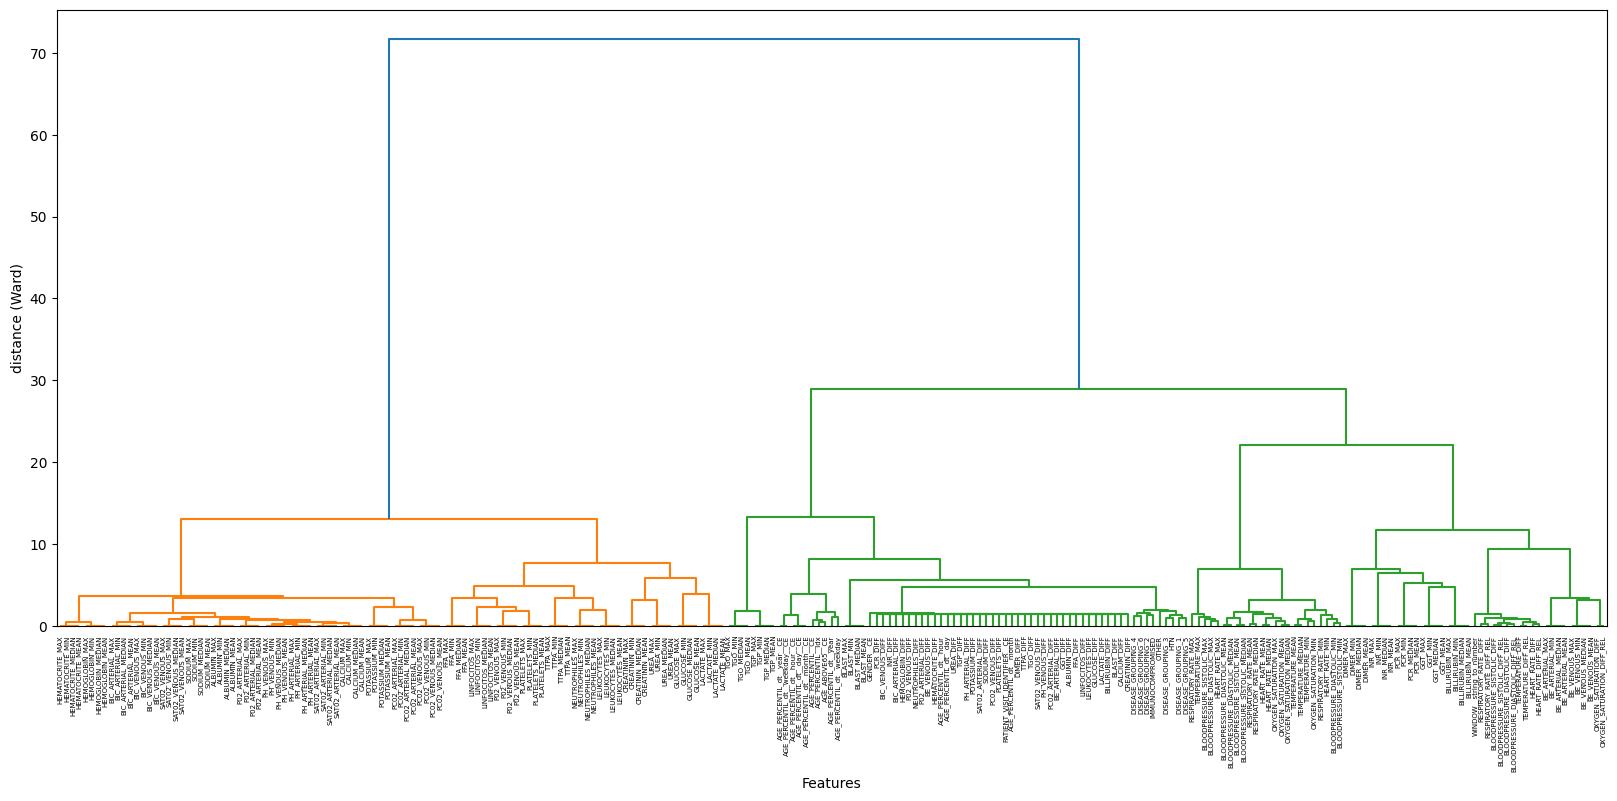

Selecting features bassed on the dendogram
Total number of features selected =  92
  execute custom_operator took 1.849245448014699 sec
execute custom_operator started ...
  execute custom_operator took 0.4481002139800694 sec
execute custom_operator started ...
Finding transform for :  PATIENT_VISIT_IDENTIFIER
The best transform is: log_transform, with absolute log of slope 0.12174339872102322
Finding transform for :  AGE_ABOVE65
The best transform is: exp_transform, with absolute log of slope 0.3786191798394859
Finding transform for :  GENDER
The best transform is: exp_transform, with absolute log of slope 0.4314295824958686
Finding transform for :  DISEASE_GROUPING_1
The best transform is: exp_transform, with absolute log of slope 1.125418809305867
Finding transform for :  DISEASE_GROUPING_2
The best transform is: exp_transform, with absolute log of slope 2.1579928340408387
Finding transform for :  DISEASE_GROUPING_3
The best transform is: exp_transform, with absolute log of slope 1.

/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/tabutils/feature_normal_transform.py:25: RuntimeWarning: divide by zero encountered in log
  return abs(np.log(res[1][0]))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


The best transform is: sqrt_transform, with absolute log of slope 2.208521074792581
Finding transform for :  INR_DIFF
The best transform is: exp_transform, with absolute log of slope 73.69622135253769
Finding transform for :  LACTATE_MEDIAN
The best transform is: reciprocal_transform, with absolute log of slope 0.007986809269357156
Finding transform for :  LACTATE_DIFF
The best transform is: exp_transform, with absolute log of slope 73.69622135253769
Finding transform for :  LEUKOCYTES_MEDIAN
The best transform is: reciprocal_transform, with absolute log of slope 0.718853446703217
Finding transform for :  LEUKOCYTES_DIFF
The best transform is: exp_transform, with absolute log of slope 73.69622135253769
Finding transform for :  LINFOCITOS_MEDIAN
The best transform is: reciprocal_transform, with absolute log of slope 0.9856011127101024
Finding transform for :  LINFOCITOS_DIFF
The best transform is: exp_transform, with absolute log of slope 73.69622135253769
Finding transform for :  NEUTR

/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/tabutils/feature_normal_transform.py:25: RuntimeWarning: invalid value encountered in log
  return abs(np.log(res[1][0]))
/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/tabutils/feature_normal_transform.py:25: RuntimeWarning: divide by zero encountered in log
  return abs(np.log(res[1][0]))
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/tabutils/feature_normal_transform.py:25: RuntimeWarning: divide by zero encountered in log
  return abs(np.log(res[1][0]))
/usr/local/lib/python3.10/dist-packages/pyrecdp/primitives/tabutils/feature_normal_transform.py:25: RuntimeWarning: inval

  execute custom_operator took 10.092578640003921 sec
execute DataFrame started ...
  execute DataFrame took 8.614995749667287e-06 sec
execute lightgbm started ...
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 1733, number of negative: 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32274
[LightGBM] [Info] Number of data points in the train set: 1733, number of used features: 392


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no

PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65    GENDER  DISEASE_GROUPING_1  DISEASE_GROUPING_2  DISEASE_GROUPING_3  DISEASE_GROUPING_4  \
0                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
1                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
2                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
3                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
4                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
...                        ...          ...       ...                 ...                 ...                 ...                 ...   
1920              5.953243e+00     1.000000  2.718282                 1.0                 1.0            1.000000                 1.0   
1921              5.953243e+00     1.000000  2.718282                 1.0                 1.0            1.000000                 1.0   
1922              5.953243e+00     1.000000  2.718282                 1.0                 1.0            1.000000                 1.0   
1923              5.953243e+00     1.000000  2.718282                 1.0                 1.0            1.000000                 1.0   
1924              5.953243e+00     1.000000  2.718282                 1.0                 1.0            2.718282                 1.0   

      DISEASE_GROUPING_6  IMMUNOCOMPROMISED     OTHER  ALBUMIN_MEDIAN  ALBUMIN_DIFF  BE_ARTERIAL_MEDIAN  BE_ARTERIAL_DIFF  BE_VENOUS_MEDIAN  \
0               2.718282                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
1               2.718282                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
2               2.718282                1.0  2.718282        0.526968      0.367879           -1.000000          0.367879         -1.000000   
3               2.718282                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
4               2.718282                1.0  2.718282        0.000000      0.367879           -1.147239          0.367879         -1.157576   
...                  ...                ...       ...             ...           ...                 ...               ...               ...   
1920            1.000000                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
1921            1.000000                1.0  2.718282        0.526968      0.367879           -1.000000          0.367879         -1.394161   
1922            1.000000                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
1923            1.000000                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
1924            1.000000                1.0  2.718282        0.526968      0.367879           -1.000000          0.367879         -1.000000   

      BE_VENOUS_DIFF  BIC_ARTERIAL_MEDIAN  BIC_ARTERIAL_DIFF  BIC_VENOUS_DIFF  BILLIRUBIN_MEDIAN  BILLIRUBIN_DIFF  BLAST_MEDIAN  BLAST_DIFF  \
0           0.367879            -1.000000           0.367879         0.367879       1.000000e-08         0.367879          -1.0    0.367879   
1           0.367879            -1.000000           0.367879         0.367879       1.000000e-08         0.367879          -1.0    0.367879   
2           0.367879            -3.153846           0.367879         0.367879       2.470831e-01         0.367879          -1.0    0.367879   
3           0.367879            -1.000000           0.367879         0.3

In [4]:
from pyrecdp.autofe import AutoFE

pipeline = AutoFE(dataset=load_data(), label=target_label)

# Add tabular-utils function to recdp
pipeline.add_operation(select_feature_from_covid_data)
pipeline.add_operation(feature_impute_for_covid_data)
pipeline.add_operation(generate_domain_specific_features_from_covid_data)

pipeline.fit_transform(engine_type = engine_type)

## 3. AutoFE Deep dive 

In below section, you'll see advanced interfaces provided by AutoFE pipeline. So you will be able to custom auto generated pipeline EDA report of original data.

* To view the EDA profiling of original data.
``` python
pipeline.profile(engine_type)
```

* To view generated data pipeline and customize data pipeline.
``` python
pipeline.plot()
```

* To view feature importance result.
``` python
pipeline.feature_importance()
```

### 3.1 Feature Profiling
AutoFE provides feature profiler to analyze the feature distribution and identify insights of feature.

execute with pandas started ...
execute DataFrame started ...
  execute DataFrame took 0.005470934993354604 sec
execute type_infer started ...
  execute type_infer took 0.019678511016536504 sec
execute time_series_infer started ...
  execute time_series_infer took 5.61200431548059e-06 sec
execute string_to_number started ...
  execute string_to_number took 0.003563384001608938 sec
execute astype started ...
  execute astype took 0.02752924000378698 sec
execute with pandas took 0.05634499801089987 sec
prepare info for PATIENT_VISIT_IDENTIFIER started ...
prepare info for PATIENT_VISIT_IDENTIFIER took 0.0019019079918507487 sec
prepare info for AGE_ABOVE65 started ...
prepare info for AGE_ABOVE65 took 0.0015871099894866347 sec
prepare info for AGE_PERCENTIL started ...
prepare info for AGE_PERCENTIL took 0.004124600003706291 sec
prepare info for GENDER started ...
prepare info for GENDER took 0.0015982069890014827 sec
prepare info for DISEASE GROUPING 1 started ...
prepare info for DISEAS

/usr/local/lib/python3.10/dist-packages/pyrecdp/core/dataframe.py:19: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'may_sample' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def may_sample(df, nrows = 100000):
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 617.58it/s]


prepare xy scatter plot completed
Draw xy scatter plot took 16.905338582990225 sec



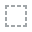
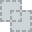
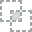
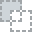
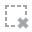
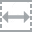
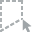
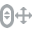
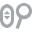
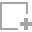
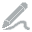
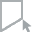
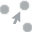
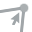
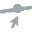
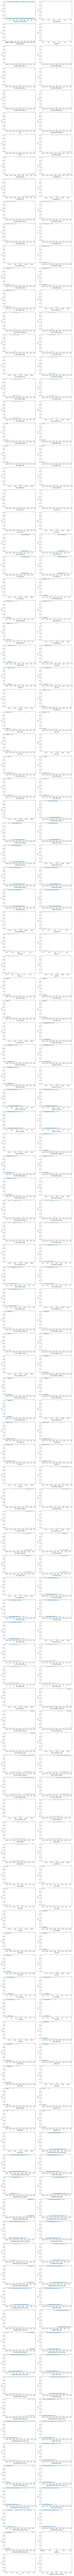

In [5]:
pipeline.profile(engine_type)

## 3.2 Pipeline Plot

view or modify pipeline is supported

* view pipeline
```
pipeline.plot()
```

* add new operation to pipeline

``` python
def gussian_calulation(df):
    df = apply_gussian(df, columns= ['col_1'])
    return df

pipeline.add_operation(gussian_calulation)
```

* remove unwanted operation from pipeline

``` python
pipeline.delete_operation(id = 6)
```

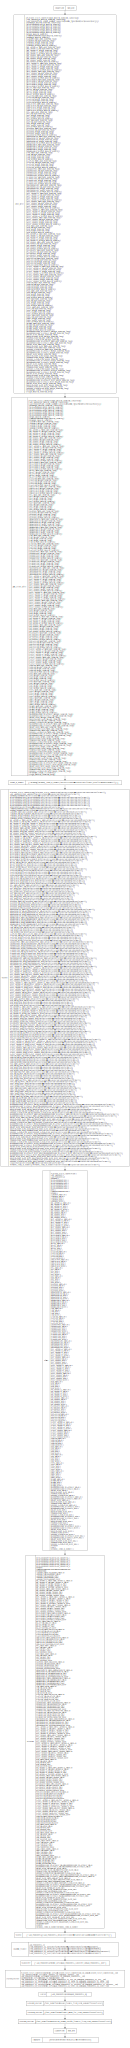

In [6]:
pipeline.plot()

## 3.3 Feature Importance

We provided feature estimators to analyze transformed data, and do feature reduction in case autoFE generated unuseful features.

Series([], dtype: int64)

/usr/local/lib/python3.10/dist-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/usr/local/lib/python3.10/dist-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/usr/local/lib/python3.10/dist-packages/matplotlib/patches.py:743: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:2039: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty


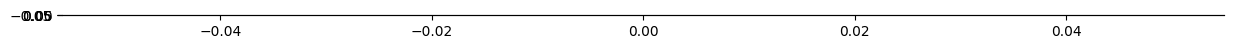

In [7]:
pipeline.feature_importance()

## 4. Model training

Now, autoFE is completed, let's achieve transformed data and fit it to your own model.

In [8]:
transformed_data = pipeline.get_transformed_data()

In [9]:
transformed_data

PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65    GENDER  DISEASE_GROUPING_1  DISEASE_GROUPING_2  DISEASE_GROUPING_3  DISEASE_GROUPING_4  \
0                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
1                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
2                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
3                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
4                 1.000000e-16     2.718282  1.000000                 1.0                 1.0            1.000000                 1.0   
...                        ...          ...       ...                 ...                 ...                 ...                 ...   
1920              5.953243e+00     1.000000  2.718282                 1.0                 1.0            1.000000                 1.0   
1921              5.953243e+00     1.000000  2.718282                 1.0                 1.0            1.000000                 1.0   
1922              5.953243e+00     1.000000  2.718282                 1.0                 1.0            1.000000                 1.0   
1923              5.953243e+00     1.000000  2.718282                 1.0                 1.0            1.000000                 1.0   
1924              5.953243e+00     1.000000  2.718282                 1.0                 1.0            2.718282                 1.0   

      DISEASE_GROUPING_6  IMMUNOCOMPROMISED     OTHER  ALBUMIN_MEDIAN  ALBUMIN_DIFF  BE_ARTERIAL_MEDIAN  BE_ARTERIAL_DIFF  BE_VENOUS_MEDIAN  \
0               2.718282                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
1               2.718282                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
2               2.718282                1.0  2.718282        0.526968      0.367879           -1.000000          0.367879         -1.000000   
3               2.718282                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
4               2.718282                1.0  2.718282        0.000000      0.367879           -1.147239          0.367879         -1.157576   
...                  ...                ...       ...             ...           ...                 ...               ...               ...   
1920            1.000000                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
1921            1.000000                1.0  2.718282        0.526968      0.367879           -1.000000          0.367879         -1.394161   
1922            1.000000                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
1923            1.000000                1.0  2.718282       -1.245934      0.367879           -1.000000          0.367879         -1.000000   
1924            1.000000                1.0  2.718282        0.526968      0.367879           -1.000000          0.367879         -1.000000   

      BE_VENOUS_DIFF  BIC_ARTERIAL_MEDIAN  BIC_ARTERIAL_DIFF  BIC_VENOUS_DIFF  BILLIRUBIN_MEDIAN  BILLIRUBIN_DIFF  BLAST_MEDIAN  BLAST_DIFF  \
0           0.367879            -1.000000           0.367879         0.367879       1.000000e-08         0.367879          -1.0    0.367879   
1           0.367879            -1.000000           0.367879         0.367879       1.000000e-08         0.367879          -1.0    0.367879   
2           0.367879            -3.153846           0.367879         0.367879       2.470831e-01         0.367879          -1.0    0.367879   
3           0.367879            -1.000000           0.367879         0.3